<a href="https://colab.research.google.com/github/jwang44/upgraded-octo-chainsaw/blob/main/DataVisualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/551 A3'
!ls

/content/drive/MyDrive/551 A3
 ExampleSubmissionRandom.csv  'Train_labels (1).csv'   VAL_ACCU_RES34.csv
 LoadData.ipynb		       Train_labels.csv        VAL_ACCU_TUTOR.csv
 piechart.png		       Train.pkl
 Test.pkl		       VAL_ACCU_RES18.csv


In [5]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, TensorDataset
from PIL import Image
import torch
import pandas as pd

## Dataset Class / Data Loaders

In [ ]:
IMG_SIZE = (224, 224)

In [ ]:
# Transforms are common image transformations. They can be chained together using Compose.
# Here we normalize images img=(img-0.5)/0.5
img_transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize([0.5], [0.5]),
    transforms.Resize(IMG_SIZE)  
    # transforms.RandomRotation(10, resample=PIL.Image.BILINEAR)
    # transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0)
    # transforms.RandomAffine(degrees, translate=None, scale=None, shear=None, interpolation=<InterpolationMode.NEAREST: 'nearest'>, fill=0, fillcolor=None, resample=None)
])

In [ ]:
# img_file: the pickle file containing the images
# label_file: the .csv file containing the labels
# transform: We use it for normalizing images (see above)
# idx: This is a binary vector that is useful for creating training and validation set.
# It return only samples where idx is True

class MyDataset(Dataset):
    def __init__(self, img_file, label_file, transform=None, idx = None):
        self.data = pickle.load( open( img_file, 'rb' ), encoding='bytes')
        self.targets = np.genfromtxt(label_file, delimiter=',', skip_header=1, usecols=1) #[:,1:]
        if idx is not None:
          self.targets = self.targets[idx]
          self.data = self.data[idx]
        self.transform = transform

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):
        img, target = self.data[index].squeeze(), int(self.targets[index])
        img = Image.fromarray((img*255).astype('uint8'), mode='L')
        if self.transform is not None:
           img = self.transform(img)
        return img, target

Get loader for all train data

In [ ]:
BATCH_SIZE = 128
dataset = MyDataset(TRAIN_DATA_PATH, TRAIN_LABEL_PATH,transform=img_transform, idx=None)
# dataloader for all data
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

## Distribution

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from collections import OrderedDict

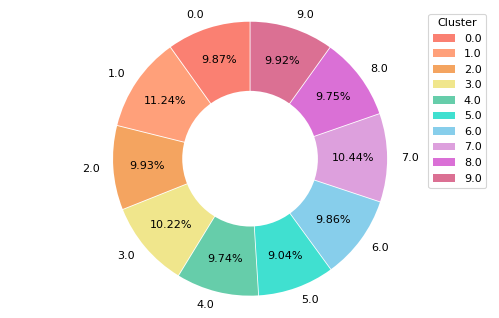

In [ ]:
# draw distribution

y_labels = Counter(dataset.targets)
y_labels = OrderedDict(sorted(y_labels.items()))

plt.figure(figsize=(7.8,5),dpi=80) # fig size
plt_labels = list(y_labels.keys()) # label
sizes = list(y_labels.values())

colors = ['salmon', 'lightsalmon', 'sandybrown', 'khaki', 'mediumaquamarine', 'turquoise','skyblue', 'plum', 'orchid', 'palevioletred'] # color of each sector
explode = (0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01)
patches,text1,text2 = plt.pie(sizes,   
                      explode = explode,         
                      labels=plt_labels,
                      colors=colors,
                      # labeldistance = 1.2,
                      labeldistance = 1.1,
                      autopct = '%3.2f%%', 
                      shadow = False, 
                      startangle = 90, 
                      pctdistance = 0.75) 
# draw the circle to make donut
circle = plt.Circle((0,0),0.5,fc='white')
donut = plt.gcf()
donut.gca().add_artist(circle)
# patches: pie chart，texts1: label text，texts2: pie chart text
plt.axis('equal')
plt.legend(title = 'Cluster',loc='upper right')
plt.savefig('piechart.png')
plt.show()

## Accu 

In [6]:
res18 = pd.read_csv('VAL_ACCU_RES18.csv')
res18_rot = pd.read_csv('VAL_ACCU_RES18_ROTATE.csv')
res34 = pd.read_csv('VAL_ACCU_RES34.csv')
tutor = pd.read_csv('VAL_ACCU_TUTOR.csv')

In [7]:
epoch = res18.iloc[:,0]+1

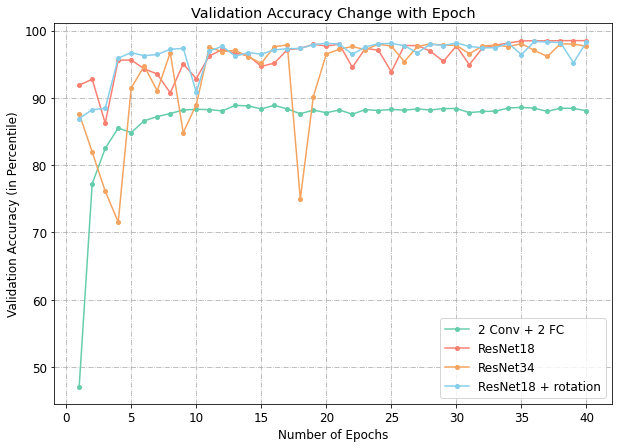

In [15]:

# Data
df=pd.DataFrame({'epoch': epoch, '2 Conv + 2 FC': tutor.iloc[:,1], 'ResNet18': res18.iloc[:,1], 'ResNet18 + rotation': res18_rot.iloc[:,1], 'ResNet34': res34.iloc[:,1]})
plt.figure(figsize=(10,7))
plt.rcParams['font.size'] = '12'
# multiple line plots

plt.plot( 'epoch', '2 Conv + 2 FC', data=df, marker='.', markerfacecolor='mediumaquamarine', markersize=8, color='mediumaquamarine', label='2 Conv + 2 FC')
plt.plot( 'epoch', 'ResNet18', data=df, marker='.', markerfacecolor='salmon', markersize=8, color='salmon', label='ResNet18')
plt.plot( 'epoch', 'ResNet34', data=df, marker='.', markerfacecolor='sandybrown', markersize=8, color='sandybrown', label='ResNet34')
plt.plot( 'epoch', 'ResNet18 + rotation', data=df, marker='.', markerfacecolor='skyblue', markersize=8, color='skyblue', label='ResNet18 + rotation')
plt.grid(linestyle='-.')
plt.legend()
plt.title('Validation Accuracy Change with Epoch')
plt.xlabel('Number of Epochs')
plt.ylabel('Validation Accuracy (in Percentile)')
plt.savefig('accu.png')
plt.show()